In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv(r'C:\Users\jaspe\OneDrive\Documents\Credit Risk Prediction\Credit Risk Analysis\credit_data.csv')
data

,clientid,income,age,loan,default
0,1,66155.92510,59.017015,8106.532131,0
1,2,34415.15397,48.117153,6564.745018,0
2,3,57317.17006,63.108049,8020.953296,0
3,4,42709.53420,45.751972,6103.642260,0
4,5,66952.68885,18.584336,8770.099235,1
...,...,...,...,...,...
1995,1996,59221.04487,48.518179,1926.729397,0
1996,1997,69516.12757,23.162104,3503.176156,0
1997,1998,44311.44926,28.017167,5522.786693,1
1998,1999,43756.05660,63.971796,1622.722598,0


In [3]:
data = pd.DataFrame(data)

In [4]:
data.describe()

,clientid,income,age,loan,default
count,2000.000000,2000.000000,1997.000000,2000.000000,2000.000000
mean,1000.500000,45331.600018,40.807559,4444.369695,0.141500
std,577.494589,14326.327119,13.624469,3045.410024,0.348624
min,1.000000,20014.489470,-52.423280,1.377630,0.000000
25%,500.750000,32796.459720,28.990415,1939.708847,0.000000
50%,1000.500000,45789.117310,41.317159,3974.719418,0.000000
75%,1500.250000,57791.281670,52.587040,6432.410625,0.000000
max,2000.000000,69995.685580,63.971796,13766.051240,1.000000


In [5]:
data.dtypes

clientid      int64
income      float64
age         float64
loan        float64
default       int64
dtype: object

In [6]:
data.isna().sum()

clientid    0
income      0
age         3
loan        0
default     0
dtype: int64

In [7]:
#Binary
#Assume 1 = Give Loan, 0 = Don't give loan
data['default'].unique()

array([0, 1], dtype=int64)

<Axes: >

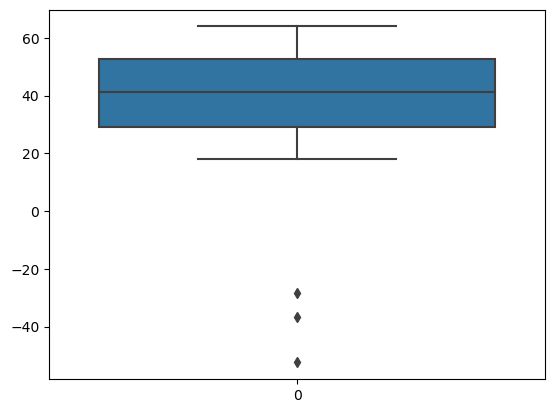

In [8]:
sns.boxplot(data['age'])

Clear evidence of negative values for age, which does not make sense. 
- There are only 3 observations seen in the data
- We can safely remove them as it won't make any significant difference in our analysis

We've also seen that we have 3 null values. Due to the normal distribution of our age data points, we can use the mean to impute our missintg data

In [9]:
#address null values
data['age'].fillna(data['age'].mean(), inplace=True)

In [10]:
data.isna().sum()

clientid    0
income      0
age         0
loan        0
default     0
dtype: int64

Since we only have 3 observations out of 2000, we can safely remove it.

In [11]:
cleaned_data = data.loc[data['age'] > 0]
cleaned_data.shape

(1997, 5)

In [12]:
cleaned_data.corr()

,clientid,income,age,loan,default
clientid,1.000000,0.039980,-0.030488,0.020231,-0.021228
income,0.039980,1.000000,-0.033226,0.440652,0.002428
age,-0.030488,-0.033226,1.000000,0.006687,-0.445187
loan,0.020231,0.440652,0.006687,1.000000,0.377779
default,-0.021228,0.002428,-0.445187,0.377779,1.000000


No clear sign of multicollinearity -> Good

<Axes: xlabel='income', ylabel='loan'>

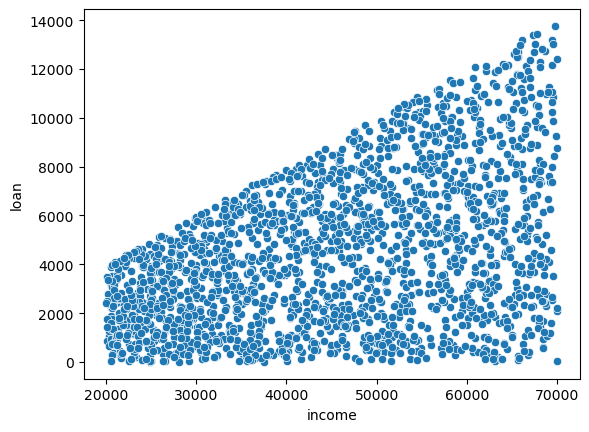

In [13]:
sns.scatterplot(x = cleaned_data['income'], y = cleaned_data['loan'])

Slightly weak linear relationship between loan and income

Let's simplify our analysis in terms of relationships. We'll create 3 buckets for our ages:
- Age <= 25: Young Age
- Age > 25 and Age < 50: Middle Age
- Age > 50: Old Age


In [14]:
age_buckets = []  # Renamed to avoid confusion with the function name
for age in range(len(cleaned_data['age'])):
    if age <= 30:
        age_buckets.append('Young')
    elif 30 < age < 50:  # Simplified condition
        age_buckets.append('Middle')
    else:
        age_buckets.append('Old')

In [15]:
#Create new column
cleaned_data['age_bucket'] = age_buckets

C:\Users\jaspe\AppData\Local\Temp\ipykernel_17976\1288285953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['age_bucket'] = age_buckets


In [16]:
cleaned_data

,clientid,income,age,loan,default,age_bucket
0,1,66155.92510,59.017015,8106.532131,0,Young
1,2,34415.15397,48.117153,6564.745018,0,Young
2,3,57317.17006,63.108049,8020.953296,0,Young
3,4,42709.53420,45.751972,6103.642260,0,Young
4,5,66952.68885,18.584336,8770.099235,1,Young
...,...,...,...,...,...,...
1995,1996,59221.04487,48.518179,1926.729397,0,Old
1996,1997,69516.12757,23.162104,3503.176156,0,Old
1997,1998,44311.44926,28.017167,5522.786693,1,Old
1998,1999,43756.05660,63.971796,1622.722598,0,Old


<Axes: xlabel='age_bucket'>

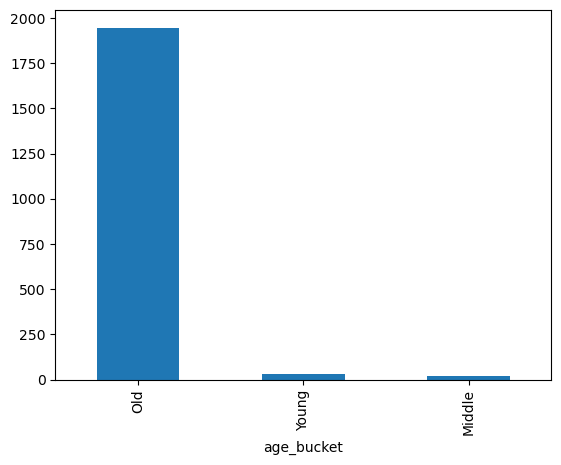

In [17]:
cleaned_data['age_bucket'].value_counts().plot(kind='bar')

There seems to be

Now that we have some key variables to play let's ask the following questions:
- What's the average income and loan for each age bucket?
- What's the maximum income and loan for each age bucket?
- What's the minimum income and loan for each age bucket?
- What's the distribution of incomes between each age bucket?
- What's the distribution of loans between each age bucket?
- What's the frequency of loans being give to each age bucket?

In [18]:
#Whats the average income for each age bucket
cleaned_data.groupby('age_bucket')[['income', 'loan']].mean()

,income,loan
age_bucket,,
Middle,45143.093305,3238.287932
Old,45319.959617,4447.104131
Young,45855.919427,4867.211123


In [19]:
#Whats the maximum income for each age bucket
cleaned_data.groupby('age_bucket')[['income', 'loan']].max()

,income,loan
age_bucket,,
Middle,68427.16311,7035.589107
Old,69995.68558,13766.051240
Young,67252.90061,10871.186790


In [20]:
#Whats the minimum income for each age bucket
cleaned_data.groupby('age_bucket')[['income', 'loan']].min()

,income,loan
age_bucket,,
Middle,24381.95345,341.146966
Old,20014.48947,1.377630
Young,20542.36507,15.498598


Odd? There seems to be 1.37 minimum loan given to a single record for the old category? Is there perhaps more we need to know, let's delve deeper

In [21]:
cleaned_data.loc[(cleaned_data['age_bucket']=='Old') & (cleaned_data['loan'] < 150)]

,clientid,income,age,loan,default,age_bucket
66,67,37521.01717,60.541077,8.012076,0,Old
105,106,47634.54955,44.294871,141.703818,0,Old
111,112,41631.66630,53.047655,106.090747,0,Old
117,118,63062.14210,26.585778,56.166164,0,Old
187,188,35032.64960,56.724626,135.931684,0,Old
304,305,51589.28275,50.313465,56.990974,0,Old
320,321,36132.42388,34.294260,99.449591,0,Old
431,432,30594.17656,50.043820,118.342142,0,Old
465,466,63806.32925,56.632166,114.499967,0,Old
560,561,40053.72227,27.938480,44.527246,0,Old


Typically, i would clarify this as it maybe an error, 8 dollars in principal amount does not make sense. For the purpose of this excercise we will loan amounts less than $10 (which does seem weird)

In [153]:
cleaned_data_2 = cleaned_data.loc[(cleaned_data['loan'] > 100)]
cleaned_data_2

,clientid,income,age,loan,default,age_bucket
0,1,66155.92510,59.017015,8106.532131,0,Young
1,2,34415.15397,48.117153,6564.745018,0,Young
2,3,57317.17006,63.108049,8020.953296,0,Young
3,4,42709.53420,45.751972,6103.642260,0,Young
4,5,66952.68885,18.584336,8770.099235,1,Young
...,...,...,...,...,...,...
1995,1996,59221.04487,48.518179,1926.729397,0,Old
1996,1997,69516.12757,23.162104,3503.176156,0,Old
1997,1998,44311.44926,28.017167,5522.786693,1,Old
1998,1999,43756.05660,63.971796,1622.722598,0,Old


<Axes: >

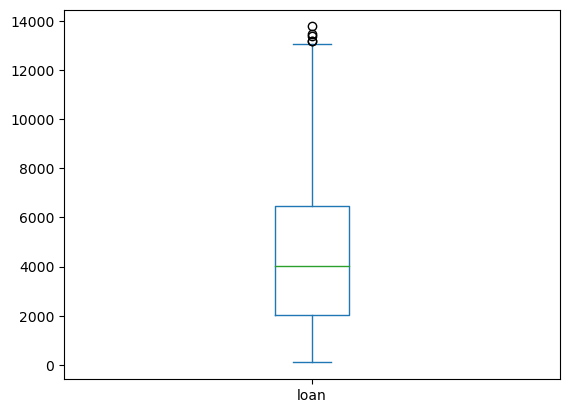

In [154]:
cleaned_data_2['loan'].plot(kind='box')

Distribution of loan data is not normal

<Axes: >

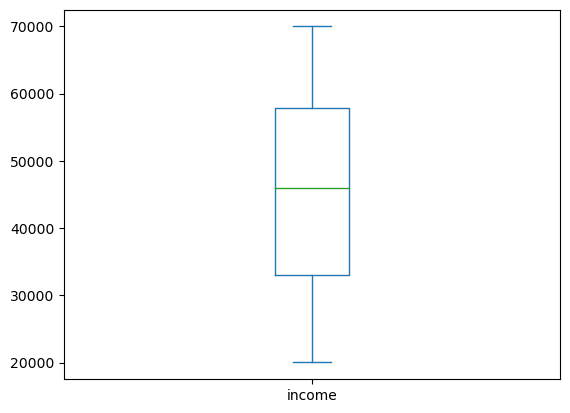

In [155]:
cleaned_data_2['income'].plot(kind='box')

<Axes: xlabel='age_bucket'>

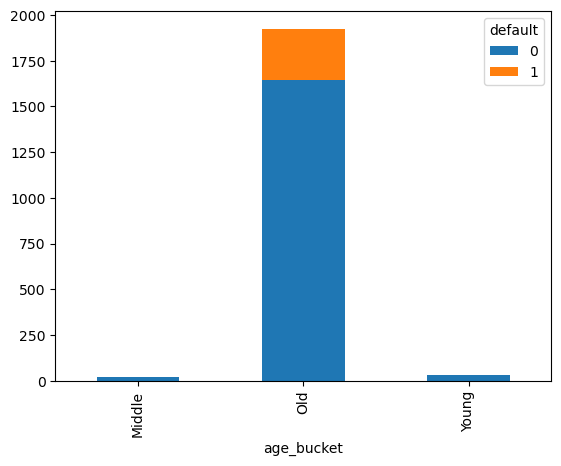

In [156]:
plot = pd.crosstab(cleaned_data_2['age_bucket'], cleaned_data_2['default'])
plot.plot(kind='bar', stacked=True)

In [157]:
plot

default,0,1
age_bucket,,
Middle,17,2
Old,1647,279
Young,28,2


Distribution for income is normal

<Axes: xlabel='age_bucket', ylabel='income'>

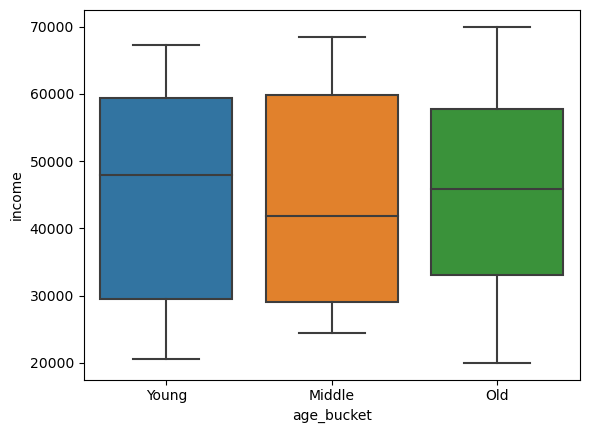

In [158]:
sns.boxplot(y=cleaned_data_2['income'], x = cleaned_data_2['age_bucket'])

<Axes: xlabel='age_bucket', ylabel='loan'>

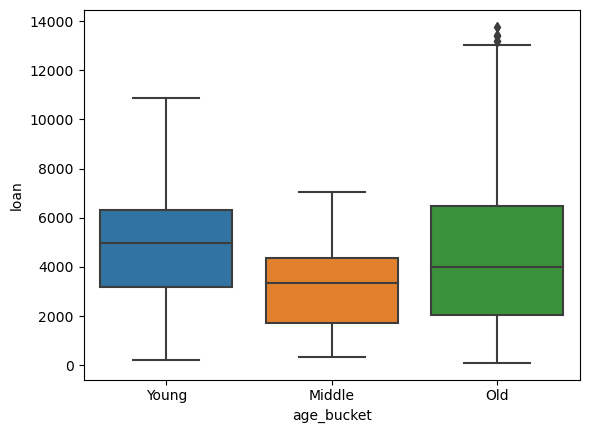

In [159]:
sns.boxplot(y=cleaned_data_2['loan'], x = cleaned_data_2['age_bucket'])

- We can see that income amounts remain relatively similar (we could test using ANOVA to see if there is a statistical significance in one more groups being different).
- Yet, when we look at loan amounts it seems that old age groups tend to get larger loan amount as compared to young and middle age groups
- Another interesting insight is that middle age groups tend to get smaller loan

Let's now build a risk model which predicts whether we get a true or false classification for their credit ratings

In [160]:
X = cleaned_data_2[['income', 'loan', 'age']]
y = cleaned_data_2['default']

In [161]:
#split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
X_train

,income,loan,age
204,29445.51050,1758.881865,28.445677
1003,23717.56785,1530.090242,49.325770
1665,48414.25154,2105.709505,21.953590
340,52945.54779,6262.007945,54.631915
1359,22001.31745,2155.812173,31.617285
...,...,...,...
1145,49032.66241,1777.953131,54.556072
1312,60856.83099,10238.496300,37.070501
872,60016.74099,1522.646768,22.738603
1479,38423.08429,3676.568354,29.209119


In [163]:
y_train

204     0
1003    0
1665    0
340     0
1359    0
       ..
1145    0
1312    0
872     0
1479    0
1141    0
Name: default, Length: 1580, dtype: int64

In [164]:
lgr = LogisticRegression(C = 1, max_iter = 10, solver='newton-cholesky',random_state=42)
lgr.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=10, random_state=42, solver='newton-cholesky')

Let's use cross validation to develop some predictions and test using a confusion matrix

In [165]:
y_pred_cv = cross_val_predict(lgr, X_train, y_train, cv=3)

Text(0.5, 1.0, 'Confusion Matrix')

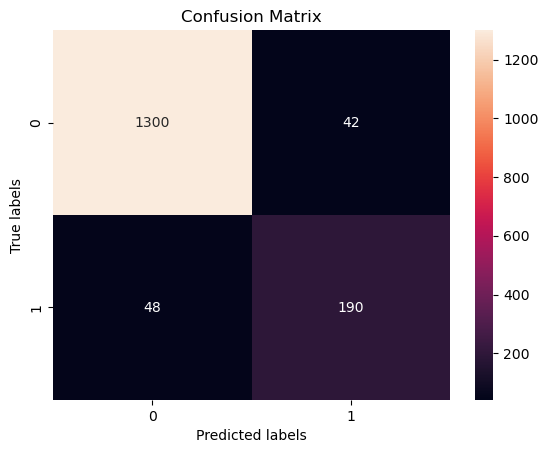

In [166]:
cm = confusion_matrix(y_train, y_pred_cv)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')

In [167]:
from sklearn.metrics import precision_score, recall_score

precision_score_lr = precision_score(y_train, y_pred_cv)
recall_score_lr = recall_score(y_train, y_pred_cv)
print("Precision " + precision_score_lr.astype(str), "\n", "Recall " + recall_score_lr.astype(str))

Precision 0.8189655172413793 
 Recall 0.7983193277310925


In [168]:
y_scores = cross_val_predict(lgr, X_train, y_train, cv = 3, method='decision_function')

In [169]:
from sklearn.metrics import precision_recall_curve

precisions, recall, thresholds = precision_recall_curve(y_train, y_scores)
print(precisions)
print(recall)
print(thresholds)

[0.15063291 0.15072831 0.15082383 ... 1.         1.         1.        ]
[1.         1.         1.         ... 0.00840336 0.00420168 0.        ]
[-27.69522272 -27.03684669 -27.01541382 ...   8.47153963   8.66851275
   9.90465208]


In [170]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = 'Precisions')
    plt.plot(thresholds, recalls[:-1], "g-", label = 'Recall')

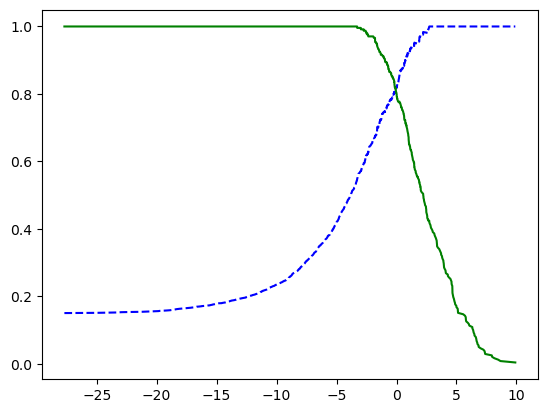

In [171]:
#Decision boundaries
plot_precision_recall_vs_threshold(precisions, recall, thresholds)

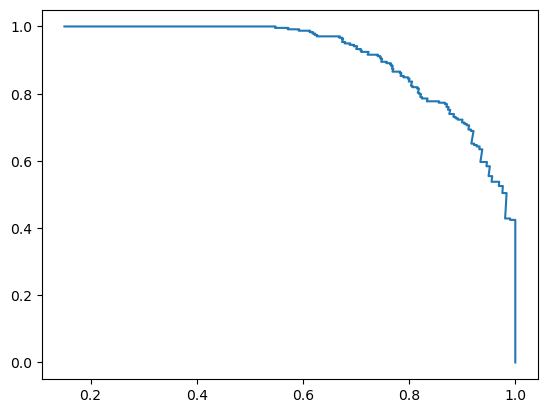

In [172]:
#PR Curve
plt.plot(precisions, recall)

In [173]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_pred_cv)

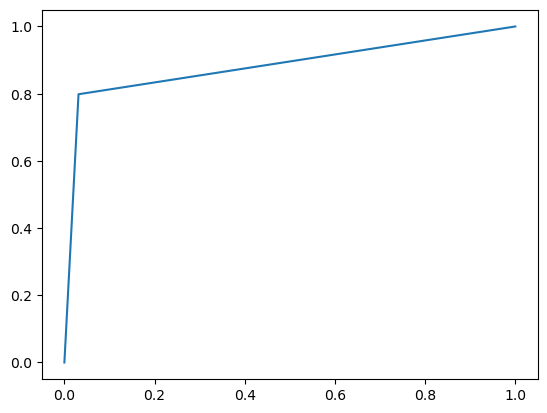

In [174]:
plt.plot(fpr, tpr)

In [175]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_scores)

0.984107502911746

Let's grid search to see whether we can further tune our model

<b>NOTE: best params are: C = 1, max_iter=10, solver='newton-cholevsky'</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
gs_lgr = GridSearchCV(lgr,
                  param_grid = {'solver': ('lbfgs', 'iblinear', 'ton-cg', 'newton-cholesky', 'sag', 'saga'),
                                'C': range(1, 5, 1),
                                'max_iter': range(10,1000,10)},
                  scoring='accuracy', verbose = 10)

gs_lgr.fit(X_train, y_train)

print(gs_lgr.best_params_)

Let's now test using our real test data

In [176]:
y_pred_normal = lgr.predict(X_test)

In [177]:
lgr_norm = confusion_matrix(y_test, y_pred_normal)
lgr_norm

array([[335,  15],
       [  7,  38]], dtype=int64)

In [178]:
y_test

1847    0
1757    0
687     0
359     0
1813    0
       ..
1608    0
76      0
774     0
265     0
55      0
Name: default, Length: 395, dtype: int64

In [179]:
y_pred_normal

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

In [180]:
precision = lgr_norm[1][1]/(lgr_norm[1][1] + lgr_norm[0][1])
precision

0.7169811320754716

In [181]:
recall = lgr_norm[1][1]/(lgr_norm[1][1] + lgr_norm[1][0])
recall

0.8444444444444444

In [182]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_normal)

0.7755102040816326

In [183]:
lgr.score(X_test,y_test)

0.9443037974683545